In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effects of scaling on global feature importance in forecasting machine learning models

## Feature scaling
We can use the two types of feature scaling methods to scale the features:
- Linear scaling like min-max, standard scaling, and robust scaling.
- Non-linear scaling like log, power, root, exponential, box-cox, yeo-johnson, and quantile scaling.

These are the formulas for the different types of scaling:
- Linear scaling: $x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$
- Standard scaling: $x' = \frac{x - \text{mean}(x)}{\text{std}(x)}$
- Robust scaling: $x' = \frac{x - \text{median}(x)}{\text{IQR}(x)}$
- Log scaling: $x' = \log(x)$
- Power scaling: $x' = x^p$
- Root scaling: $x' = \sqrt{x}$
- Exponential scaling: $x' = e^x$
- Box-Cox scaling: $x' = \frac{x^p - 1}{p}$
- Yeo-Johnson scaling: $x' = \begin{cases} \left( x + 1 \right)^p & \text{if } x \geq 0 \\ -\left( -x + 1 \right)^p & \text{if } x < 0 \end{cases}$
- Quantile scaling: $x' = \text{CDF}^{-1}(x)$

where $x$ is the original feature, $x'$ is the scaled feature, $\text{min}(x)$ is the minimum value of $x$, $\text{max}(x)$ is the maximum value of $x$, $\text{mean}(x)$ is the mean value of $x$, $\text{std}(x)$ is the standard deviation of $x$, $\text{median}(x)$ is the median value of $x$, $\text{IQR}(x)$ is the interquartile range of $x$, $p$ is the power parameter, and $\text{CDF}^{-1}(x)$ is the inverse cumulative distribution function of $x$.


### Goal
Evaluate the effects of scaling on global feature importance in forecasting machine learning models.


## Datasets:
- Linear dataset: [Ref](data\linear_dep_time_series.csv)
- Non-linear dataset: [Ref](data\nonlinear_time_series.csv)

,date,s_1,s_2,s_3,holiday,weather
0,2023-01-01,50.000000,150.000000,300.000000,0,31.852103
1,2023-01-02,100.000000,200.000000,350.000000,1,13.299608
2,2023-01-03,100.609331,195.258758,368.269784,0,29.497161
3,2023-01-04,99.437613,165.805578,351.979250,0,16.390125
4,2023-01-05,98.066940,176.120203,369.788392,0,16.449677


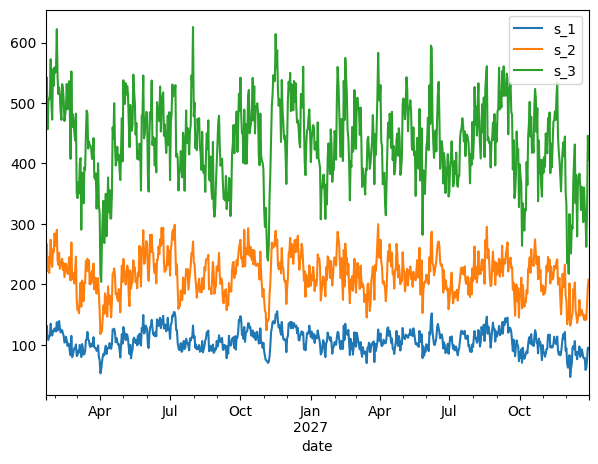

In [4]:
import pandas as pd

df_lin = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df_lin["date"] = pd.to_datetime(df_lin["date"])
df_lin.set_index("date")[series][-710:].plot(figsize=(7, 5))
display(df_lin.head())




## Preprocessing of datasets

Preprocesing steps:
- Split the series from the exogenous features.
- Transform to long format 
- Split the data into training and test sets.


C:\Users\Matty\AppData\Local\Temp\ipykernel_38772\991658549.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2027-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=364)


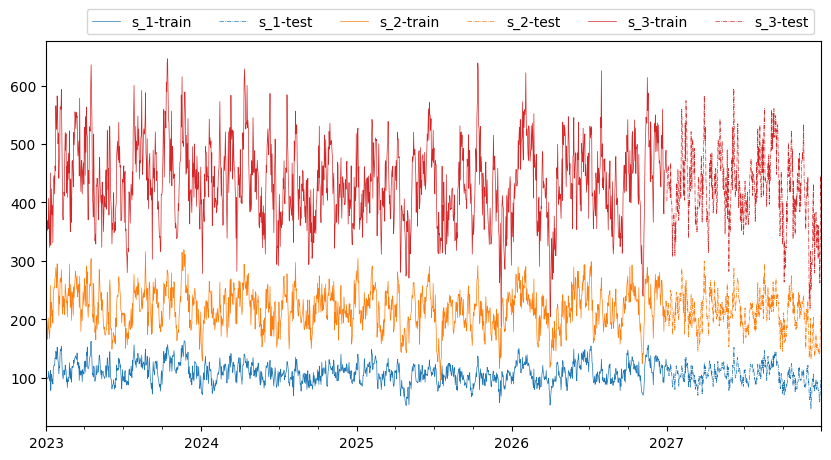

In [5]:
## Prepare linear combined data
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold


df_lin["date"] = pd.to_datetime(df_lin["date"])

# melt the series and prepare for the model
df_demand = df_lin.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df_lin[["date", "holiday", "weather"]].drop_duplicates()


#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
#df_exog["holiday"] = df_exog["holiday"].astype(bool)
df_exog["holiday"] = df_exog["holiday"].astype(int)


df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

# define split date
split_date = "2026-12-31"


lin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
lin_dataset.show_sizes()
lin_dataset.plot_series()

## Train and explain the models

Train the models:
- LigthGBM model
- Random Forest model ??

Importance metrics:
- SHAP values - Tree explainer, Kernel explainer
- Permutation feature importance - Mean average error (MAE) 

With and without scaling the features.

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.507296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.500902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training 

'Scaled : (               0\nMAE    15.058390\nMSE   444.436642\nR2      0.977546\nMAPE    0.063590,            MAE          MSE        R2      MAPE\ns_1   6.799446    71.143394  0.737403  0.067797\ns_2  12.593363   234.775498  0.764469  0.061670\ns_3  25.782362  1027.391035  0.756407  0.061303)'

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.407917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 252.400897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start train

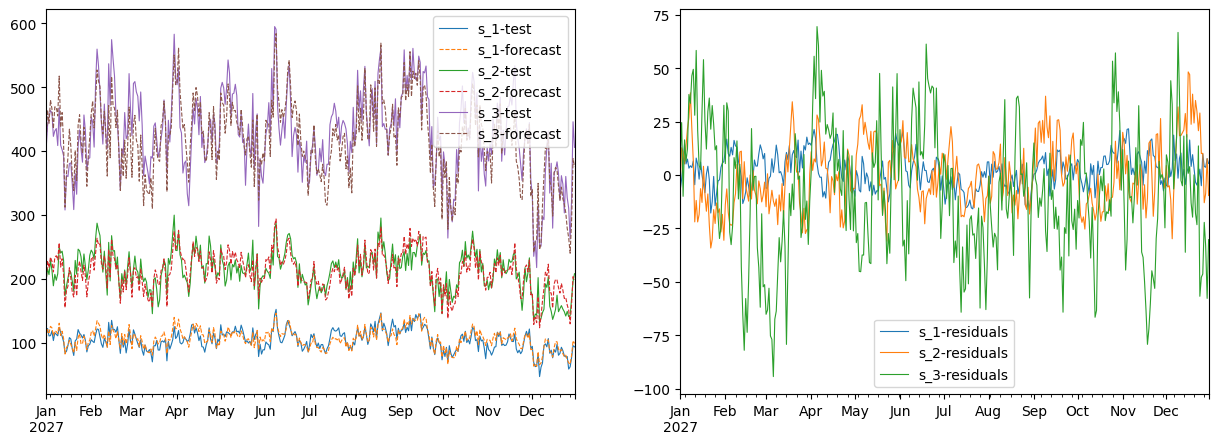

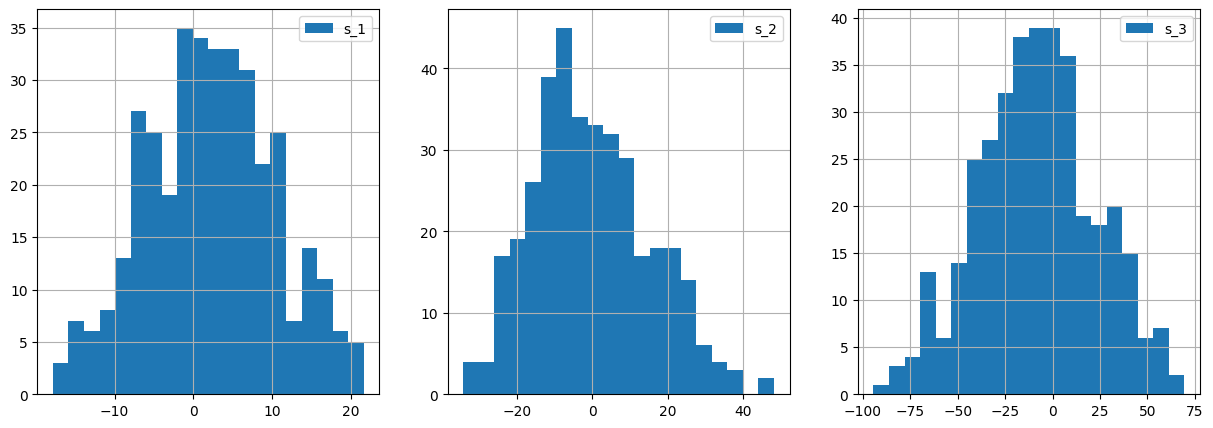

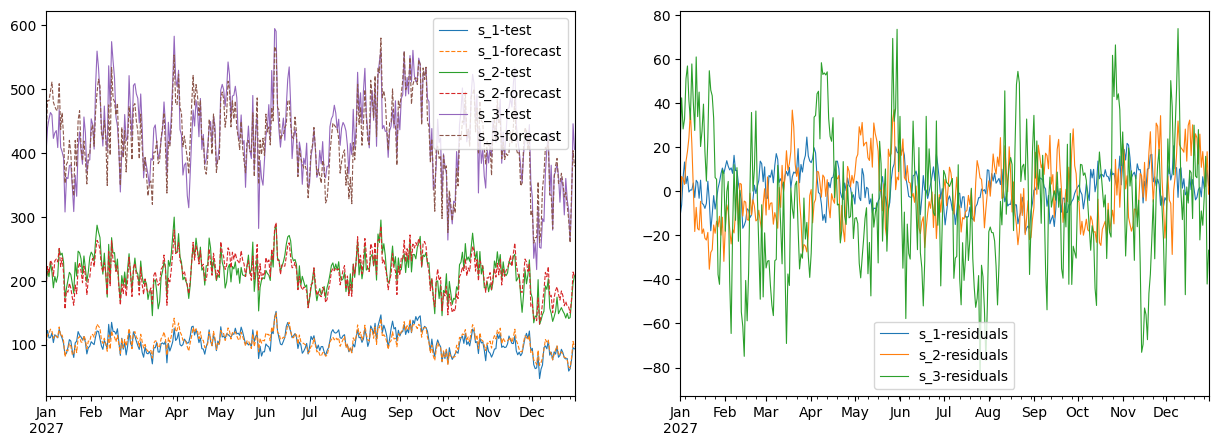

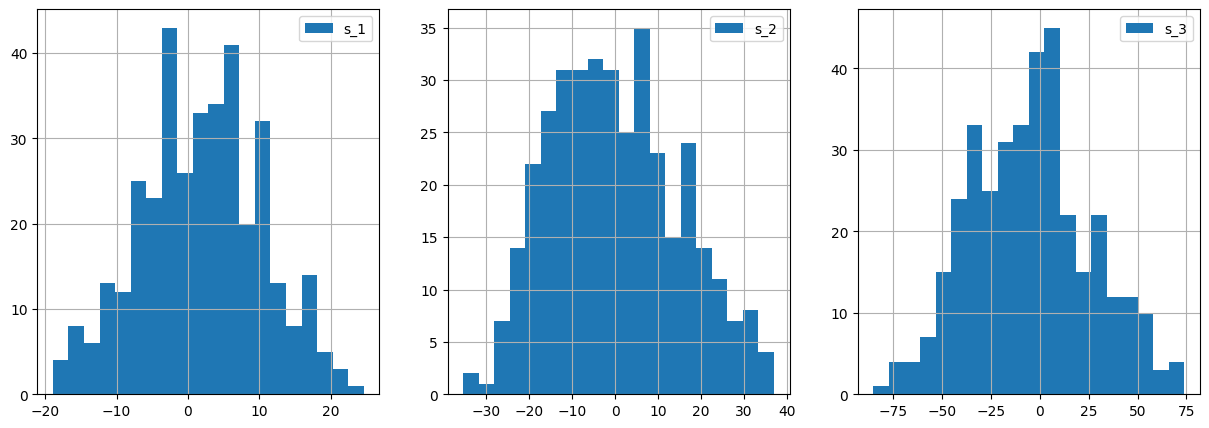

In [14]:
# forecast linear
# 
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }


regressor:LGBMRegressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
display("Scaled : "+ str(forecaster_scaled.calculate_test_performance_metrics()))
forecaster_scaled.plot_forecast()


r1regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=r1regressor,
    scale=None
    # search_space=search_space,
)
t2 = forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

forecaster_nonscaled.plot_forecast()





In [15]:
display("Scaled : ")
display(forecaster_scaled.calculate_test_performance_metrics())
display("Not scaled:")
display(forecaster_nonscaled.calculate_test_performance_metrics())

'Scaled : '

(               0
 MAE    15.058390
 MSE   444.436642
 R2      0.977546
 MAPE    0.063590,
            MAE          MSE        R2      MAPE
 s_1   6.799446    71.143394  0.737403  0.067797
 s_2  12.593363   234.775498  0.764469  0.061670
 s_3  25.782362  1027.391035  0.756407  0.061303)

'Not scaled:'

(               0
 MAE    14.729939
 MSE   415.986182
 R2      0.978984
 MAPE    0.063413,
            MAE         MSE        R2      MAPE
 s_1   7.081032   75.331302  0.721945  0.070449
 s_2  12.475931  226.210606  0.773061  0.060863
 s_3  24.632853  946.416637  0.775606  0.058925)

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 531}
  Backtesting metric: 17.455252523313405
  Levels: ['s_1', 's_2', 's_3']



(               0
 MAE    14.349349
 MSE   405.858004
 R2      0.979495
 MAPE    0.063504,
            MAE         MSE        R2      MAPE
 s_1   7.316967   81.701054  0.698433  0.074633
 s_2  11.876640  212.908095  0.786407  0.057902
 s_3  23.854440  922.964862  0.781166  0.057976)

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 531}
  Backtesting metric: 17.50581544241584
  Levels: ['s_1', 's_2', 's_3']



(               0
 MAE    14.527361
 MSE   411.440953
 R2      0.979213
 MAPE    0.064841,
            MAE         MSE        R2      MAPE
 s_1   7.284645   83.866529  0.690440  0.074453
 s_2  12.096725  226.576204  0.772694  0.060466
 s_3  24.200714  923.880126  0.780949  0.059605)

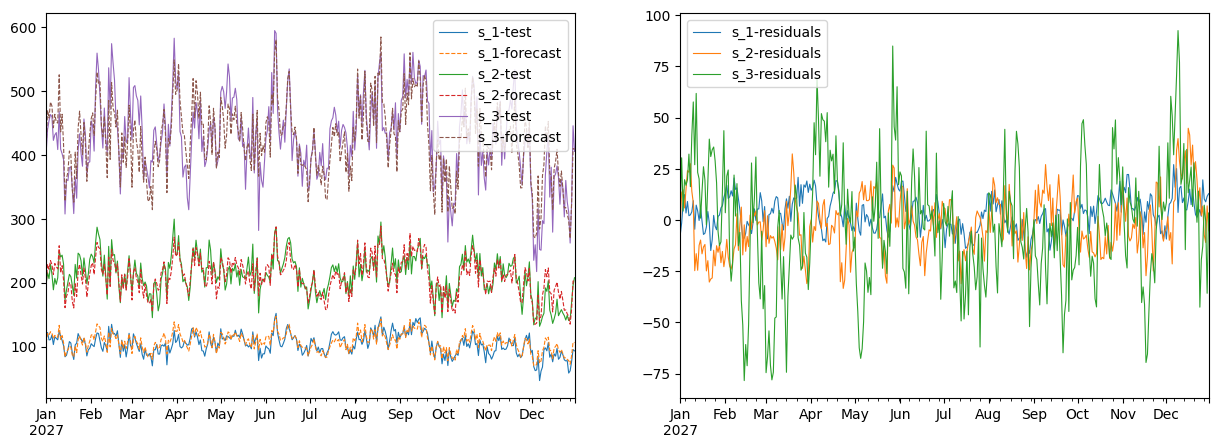

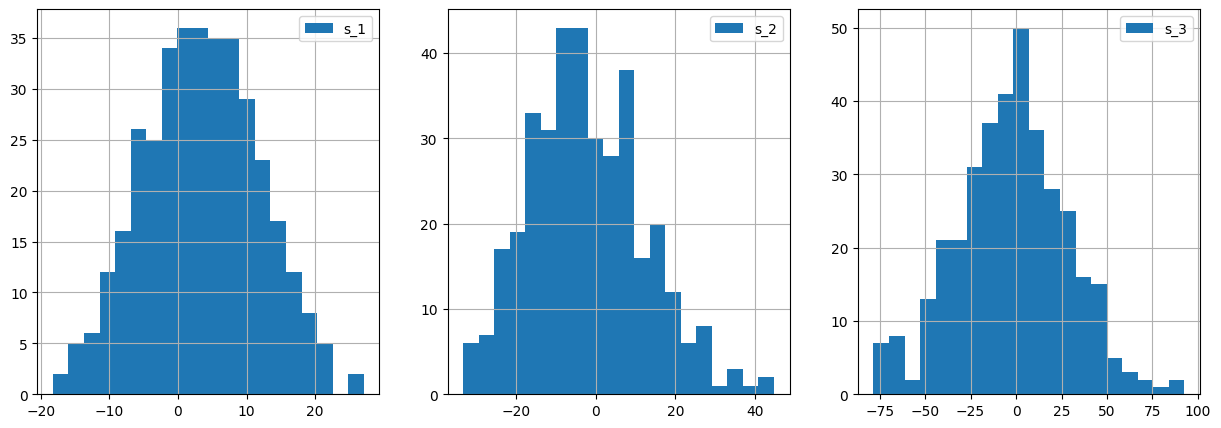

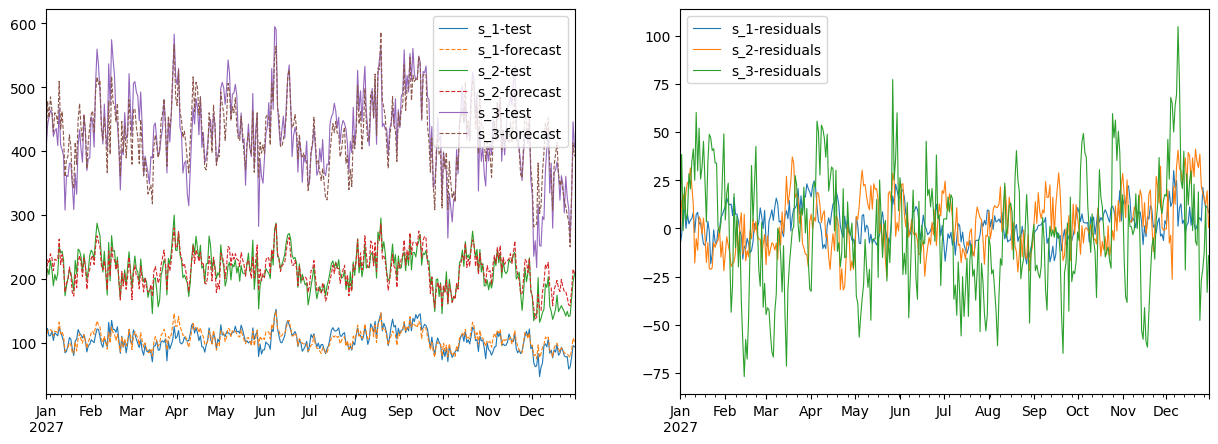

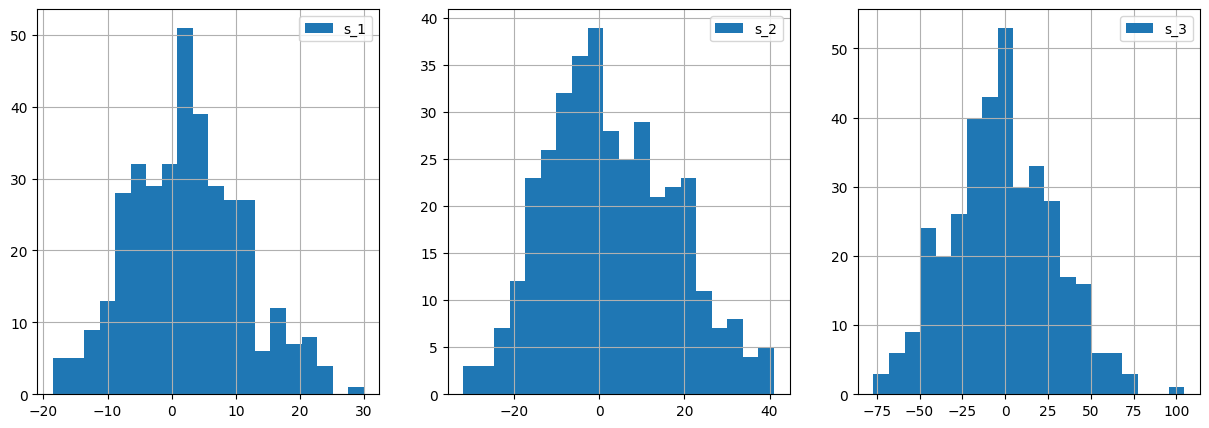

In [16]:
from tsxp.forecaster import ForecasterMsExog

from sklearn.ensemble import RandomForestRegressor

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]), #, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }

regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = rf_forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_scaled.plot_forecast()
display(rf_forecaster_scaled.calculate_test_performance_metrics())
######### Not scaled
regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=None
    # search_space=search_space,
)
t2 = rf_forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_nonscaled.plot_forecast()
display(rf_forecaster_nonscaled.calculate_test_performance_metrics())

### Model training summary

On test set the models achieve 0.97 ~R^2 score which makes sense given that the generated data has added noise.

## Feature importance calculation

Metrics calculated:
- Tree SHAP values: train and test 
- Kernel SHAP values: train and test
- PFI: ---
- Tree gain: both for LightGBM and Random Forest
- Tree split: for LightGBM

Features are also ranked and relative importance is also calculated. 

Shap is calculated for each model and dataset.

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


Calculating fast TreeSHAP values with perturbation: interventional


There may exist memory issue for algorithm v2. Switched to algorithm v1.
100%|===================| 4370/4371 [00:44<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TEST,TREE_PATH_SHAP
lag_1,0.018085,1.484342e-02,0.766832,0.716394,295.675272,1982,0.075437,0.078089
weather,0.016094,1.635455e-02,0.682413,0.789326,185.853593,2012,0.071373,0.071051
lag_2,0.002538,1.381711e-03,0.107621,0.066686,32.652512,1971,0.023601,0.022270
lag_4,0.000627,-2.394343e-06,0.026603,-0.000116,6.326154,2065,0.005290,0.004853
lag_3,0.000619,2.603537e-07,0.026258,0.000013,6.081030,1886,0.005596,0.005571
holiday,0.000284,1.909543e-04,0.012049,0.009216,2.589796,264,0.008581,0.008873
_level_skforecast,0.000200,4.122578e-06,0.008467,0.000199,1.071461,290,0.003036,0.002966


Rank                                            \
                  PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
lag_1                   1            2      1           2         1   
weather                 2            1      2           1         2   
lag_2                   3            3      3           3         3   
lag_4                   4            7      4           7         4   
lag_3                   5            6      5           6         5   
holiday                 6            4      6           4         6   
_level_skforecast       7            5      7           5         7   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1                      3              1              1  
weather                    2              2              2  
lag_2                      4              3              3  
lag_4                      1              6              6  
lag_3                      5              5              5  
holiday                    7              4              4  
_level_skforecast          6              7              7

Perc                                                 \
                     PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST  TREE_GAIN   
lag_1              47.037873    45.292131  47.037873   45.292131  55.761504   
weather            41.859593    49.903083  41.859593   49.903083  35.050195   
lag_2               6.601536     4.216054   6.601536    4.216054   6.157949   
lag_4               1.631846    -0.007306   1.631846   -0.007306   1.193052   
lag_3               1.610705     0.000794   1.610705    0.000794   1.146824   
holiday             0.739083     0.582664   0.739083    0.582664   0.488410   
_level_skforecast   0.519364     0.012579   0.519364    0.012579   0.202067   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1              18.930277      39.103839      40.319856  
weather            19.216810      36.997465      36.685986  
lag_2              18.825215      12.234161      11.498906  
lag_4              19.723018       2.742010       2.505798  
lag_3              18.013372       2.900807       2.876513  
holiday             2.521490       4.448172       4.581488  
_level_skforecast   2.769819       1.573546       1.531454

 95%|=================== | 1037/1092 [00:11<00:00]       

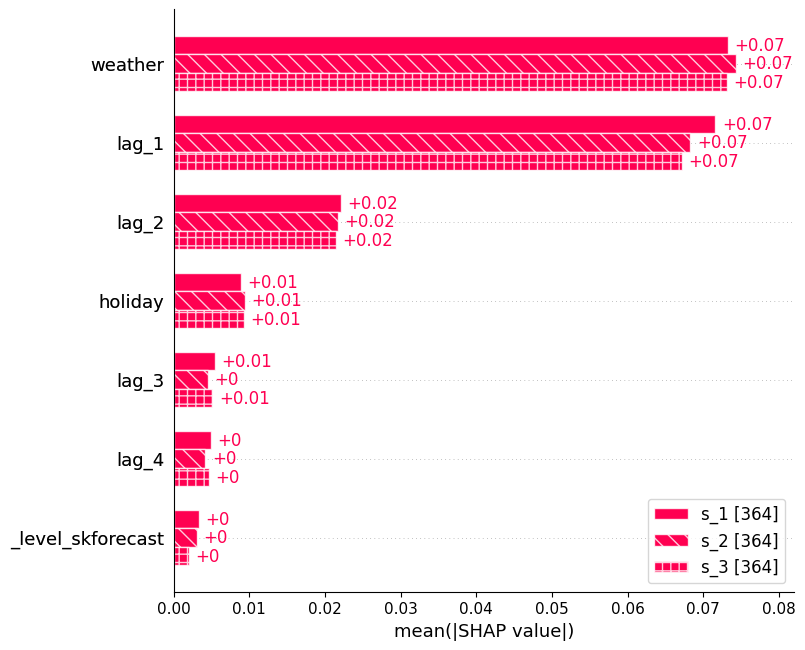

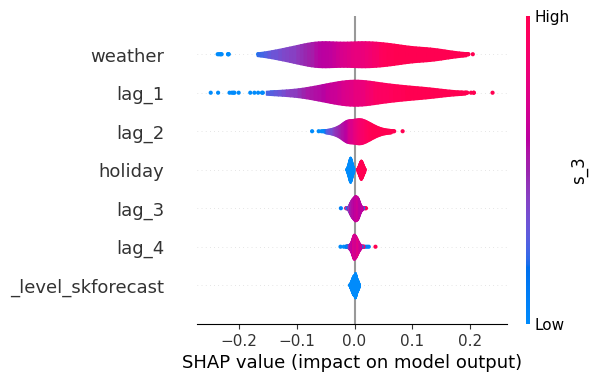

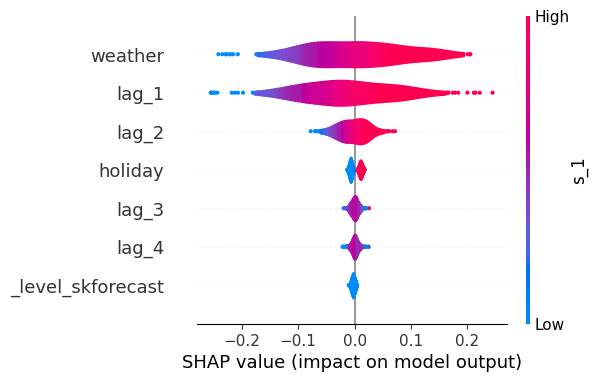

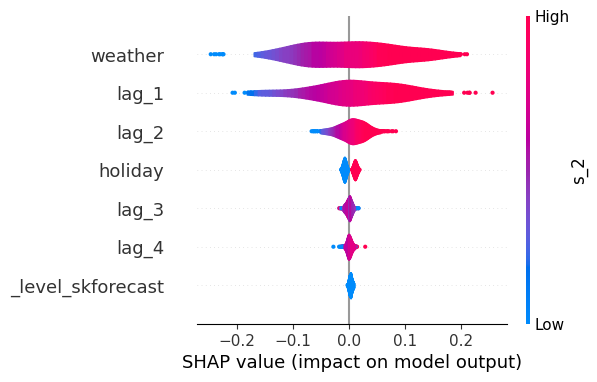

Calculating fast TreeSHAP values with perturbation: interventional


There may exist memory issue for algorithm v2. Switched to algorithm v1.
100%|===================| 4359/4371 [00:48<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TEST,TREE_PATH_SHAP
lag_1,11475.340132,11011.853237,0.561964,0.556337,1.482832e+08,2179,63.670851,57.730886
_level_skforecast,4820.678005,4718.205308,0.236076,0.238372,2.861967e+08,50,41.439805,53.795450
weather,1442.270397,1418.502272,0.070630,0.071665,1.643889e+07,2313,19.167270,18.851531
lag_2,582.831424,458.110687,0.028542,0.023145,8.346886e+06,1939,13.445188,10.158118
lag_3,87.244621,25.235785,0.004272,0.001275,8.747141e+06,1883,3.268738,5.305313
lag_4,74.811952,15.432592,0.003664,0.000780,5.754618e+05,1834,2.257544,1.768445
holiday,32.495331,19.141249,0.001591,0.000967,2.571177e+05,272,2.281740,2.482705


Rank                                            \
                  PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
lag_1                   1            1      1           1         2   
_level_skforecast       2            2      2           2         1   
weather                 3            3      3           3         3   
lag_2                   4            4      4           4         5   
lag_3                   5            5      5           5         4   
lag_4                   6            7      6           7         6   
holiday                 7            6      7           6         7   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1                      2              1              1  
_level_skforecast          7              2              2  
weather                    1              3              3  
lag_2                      3              4              4  
lag_3                      4              5              5  
lag_4                      5              7              7  
holiday                    6              6              6

Perc                                                 \
                     PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST  TREE_GAIN   
lag_1              61.976364    62.331899  61.976364   62.331899  31.627305   
_level_skforecast  26.035663    26.707103  26.035663   26.707103  61.042880   
weather             7.789458     8.029342   7.789458    8.029342   3.506250   
lag_2               3.147774     2.593107   3.147774    2.593107   1.780307   
lag_3               0.471193     0.142846   0.471193    0.142846   1.865677   
lag_4               0.404047     0.087355   0.404047    0.087355   0.122740   
holiday             0.175502     0.108348   0.175502    0.108348   0.054841   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1              20.811843      43.750673      38.463551  
_level_skforecast   0.477555      28.474872      35.841543  
weather            22.091691      13.170563      12.559946  
lag_2              18.519580       9.238702       6.767908  
lag_3              17.984718       2.246075       3.534697  
lag_4              17.516714       1.551244       1.178237  
holiday             2.597899       1.567871       1.654117

 94%|=================== | 1022/1092 [00:12<00:00]       

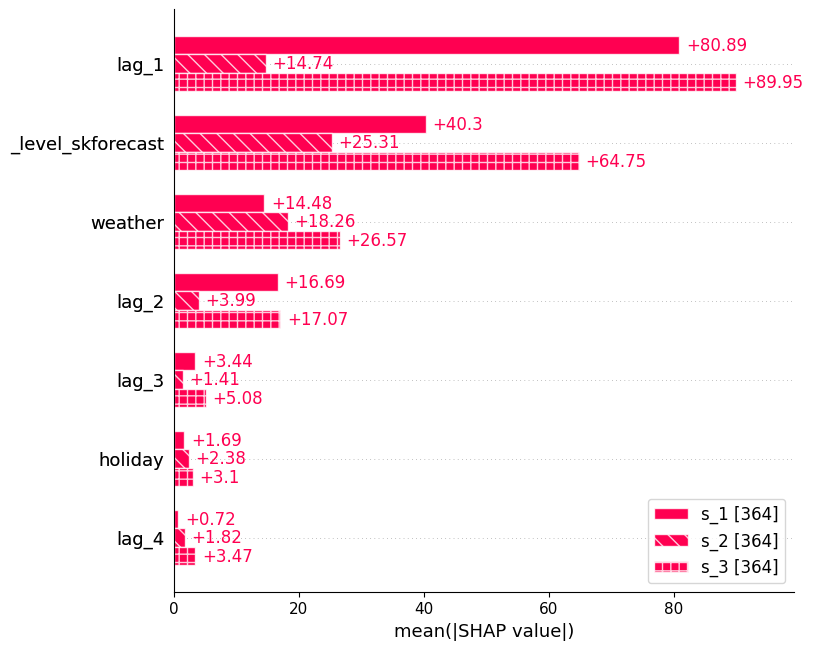

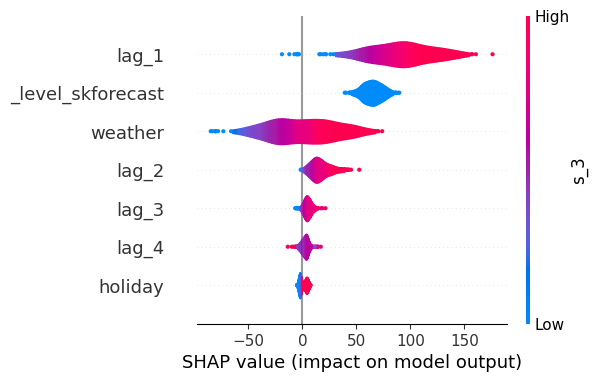

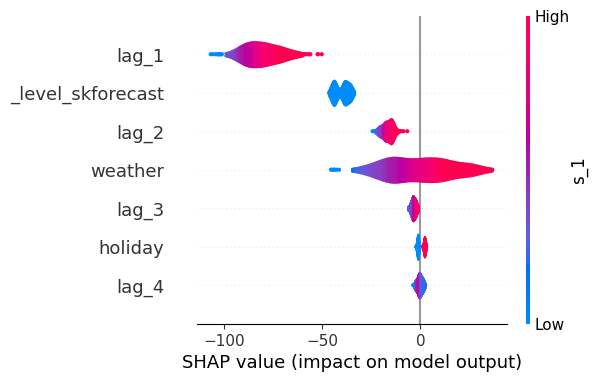

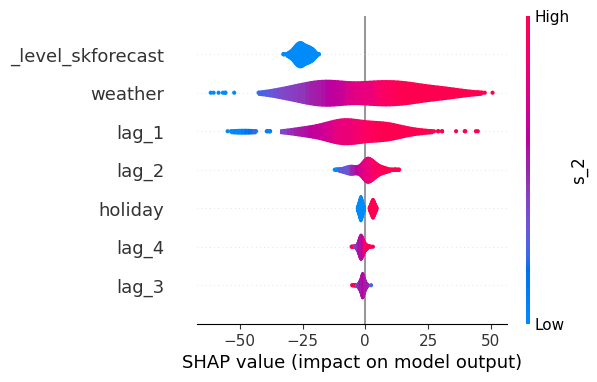

In [17]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    "lgbm_scaled": forecaster_scaled,
    "lgbm_nonscaled": forecaster_nonscaled,
    # "rf_forecaster_scaled": rf_forecaster_scaled,
    # "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}

explainers = {}

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    fi_explainer.plot_importance_for_series()
# fi_explainer = ForecasterMsExogFeatureImportance(forecaster_scaled)


Calculating fast TreeSHAP values with perturbation: interventional


There may exist memory issue for algorithm v2. Switched to algorithm v1.
100%|===================| 1087/1092 [03:42<00:01]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TEST,TREE_PATH_SHAP
lag_1,0.021468,0.017068,0.910244,0.823746,0.577556,0,0.072016,0.085200
weather,0.016709,0.016026,0.708482,0.773447,0.345105,0,0.073567,0.070595
lag_2,0.002020,0.000867,0.085632,0.041830,0.040124,0,0.016135,0.015789
lag_3,0.000395,0.000003,0.016734,0.000160,0.015248,0,0.002359,0.002706
lag_4,0.000365,0.000004,0.015467,0.000210,0.014450,0,0.001527,0.002244
holiday,0.000162,0.000081,0.006872,0.003895,0.003621,0,0.003442,0.003341
_level_skforecast,0.000102,-0.000007,0.004306,-0.000325,0.003896,0,0.000838,0.000909


Rank                                            \
                  PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
lag_1                   1            1      1           1         1   
weather                 2            2      2           2         2   
lag_2                   3            3      3           3         3   
lag_3                   4            6      4           6         4   
lag_4                   5            5      5           5         5   
holiday                 6            4      6           4         7   
_level_skforecast       7            7      7           7         6   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1                      4              2              1  
weather                    4              1              2  
lag_2                      4              3              3  
lag_3                      4              5              5  
lag_4                      4              6              6  
holiday                    4              4              4  
_level_skforecast          4              7              7

Perc                                                 \
                     PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST  TREE_GAIN   
lag_1              52.081285    50.137854  52.081285   50.137854  57.755574   
weather            40.537094    47.076377  40.537094   47.076377  34.510544   
lag_2               4.899589     2.545981   4.899589    2.545981   4.012412   
lag_3               0.957482     0.009741   0.957482    0.009741   1.524831   
lag_4               0.884978     0.012784   0.884978    0.012784   1.445017   
holiday             0.393171     0.237052   0.393171    0.237052   0.362058   
_level_skforecast   0.246400    -0.019789   0.246400   -0.019789   0.389564   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
lag_1                    NaN      42.391373      47.128092  
weather                  NaN      43.304039      39.049587  
lag_2                    NaN       9.497566       8.733653  
lag_3                    NaN       1.388708       1.496844  
lag_4                    NaN       0.899085       1.241156  
holiday                  NaN       2.025868       1.847849  
_level_skforecast        NaN       0.493362       0.502819

100%|===================| 1087/1092 [03:32<00:00]        

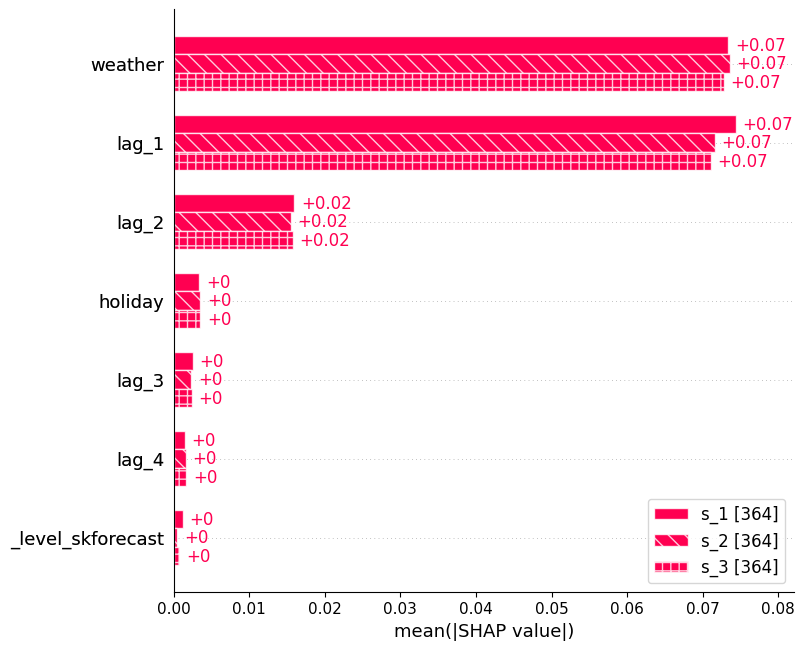

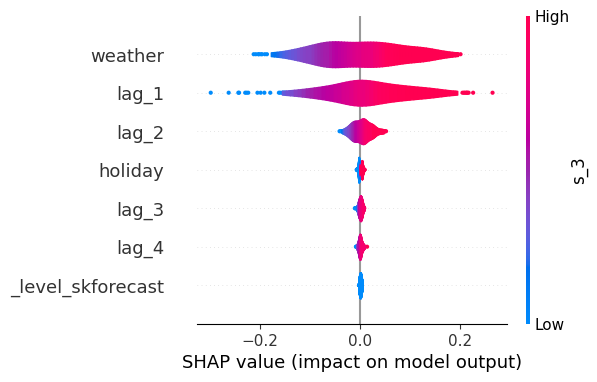

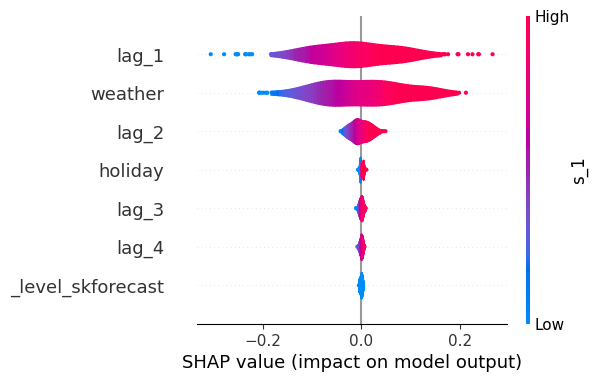

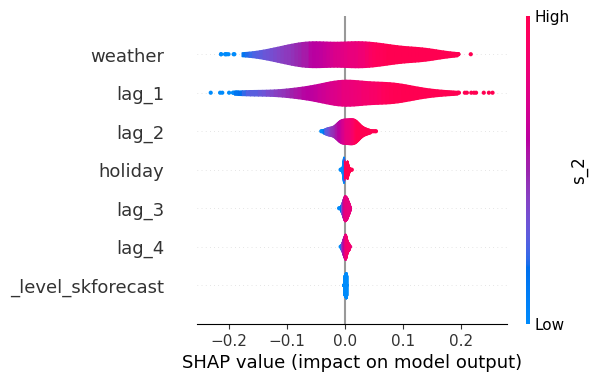

Calculating fast TreeSHAP values with perturbation: interventional


There may exist memory issue for algorithm v2. Switched to algorithm v1.
100%|===================| 1089/1092 [03:40<00:00]        

Calculating fast TreeSHAP values with perturbation: tree_path_dependent


,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_GAIN,TREE_SPLIT,TREE_SHAP_TEST,TREE_PATH_SHAP
_level_skforecast,10342.191456,9836.760160,0.506473,0.496970,0.774103,0,64.107650,89.017949
lag_1,10285.825948,9733.532441,0.503712,0.491755,0.182752,0,56.893797,45.470498
weather,1483.303847,1378.836763,0.072640,0.069661,0.034870,0,19.891315,18.176309
lag_2,197.482821,111.608311,0.009671,0.005639,0.004446,0,5.073764,3.338618
lag_3,40.733071,10.236705,0.001995,0.000517,0.001762,0,1.297344,0.864382
lag_4,35.718065,2.860560,0.001749,0.000145,0.001665,0,0.794937,0.663851
holiday,12.279243,6.141867,0.000601,0.000310,0.000403,0,0.746088,0.738740


Rank                                            \
                  PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_GAIN   
_level_skforecast       1            1      1           1         1   
lag_1                   2            2      2           2         2   
weather                 3            3      3           3         3   
lag_2                   4            4      4           4         4   
lag_3                   5            5      5           5         5   
lag_4                   6            7      6           7         6   
holiday                 7            6      7           6         7   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
_level_skforecast          4              1              1  
lag_1                      4              2              2  
weather                    4              3              3  
lag_2                      4              4              4  
lag_3                      4              5              5  
lag_4                      4              6              7  
holiday                    4              7              6

Perc                                                 \
                     PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST  TREE_GAIN   
_level_skforecast  46.175580    46.663999  46.175580   46.663999  77.410260   
lag_1              45.923921    46.174303  45.923921   46.174303  18.275181   
weather             6.622621     6.540979   6.622621    6.540979   3.486980   
lag_2               0.881717     0.529452   0.881717    0.529452   0.444631   
lag_3               0.181864     0.048561   0.181864    0.048561   0.176209   
lag_4               0.159473     0.013570   0.159473    0.013570   0.166463   
holiday             0.054824     0.029136   0.054824    0.029136   0.040275   

                                                            
                  TREE_SPLIT TREE_SHAP_TEST TREE_PATH_SHAP  
_level_skforecast        NaN      43.081681      56.244237  
lag_1                    NaN      38.233821      28.729638  
weather                  NaN      13.367380      11.484343  
lag_2                    NaN       3.409675       2.109440  
lag_3                    NaN       0.871842       0.546143  
lag_4                    NaN       0.534214       0.419441  
holiday                  NaN       0.501387       0.466758

100%|===================| 1091/1092 [03:49<00:00]        

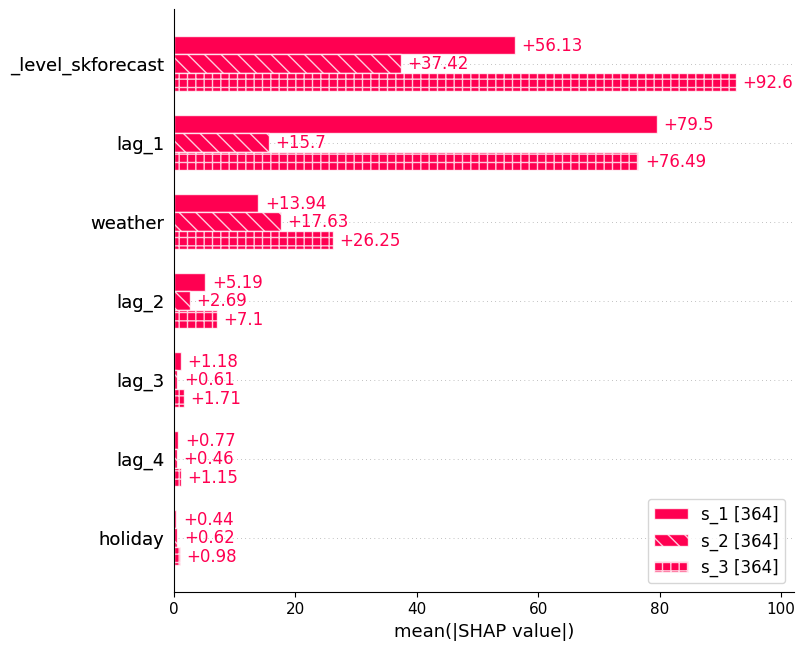

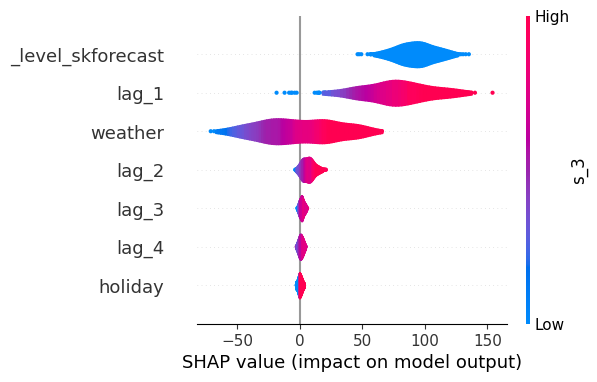

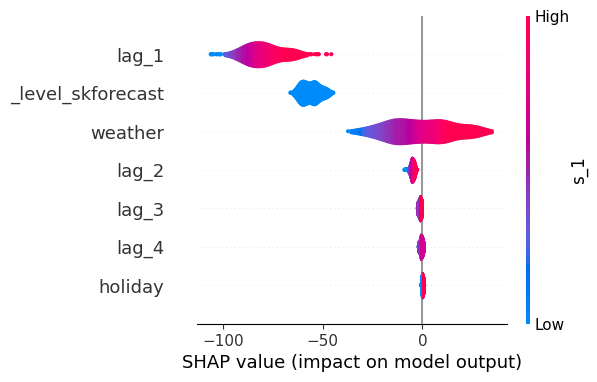

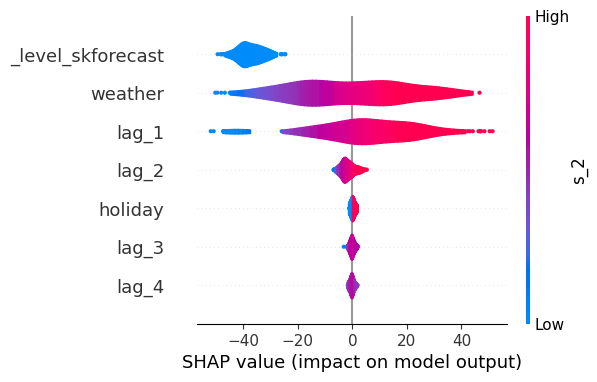

In [21]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    # "lgbm_scaled": forecaster_scaled,
    # "lgbm_nonscaled": forecaster_nonscaled,
    "rf_forecaster_scaled": rf_forecaster_scaled,
    "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}
 

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    fi_explainer.plot_importance_for_series()
# fi_explainer = ForecasterMsExogFeatureImportance(forecaster_scaled)
